This notebook is twofold in purpose: it is a tutorial intended to educate the reader on the basics of applied data science techniques and an application of those techniques to further our understanding of the psychological impact of a certain ongoing public health crisis. In particular, finding a possible link between vaccine hesitancy (or outright refusal) and depression or anxiety symptoms.
The information found here may give us






Processing:
These datasets are laid out quite differently, so a substantial amount of work must be done in order to wring insights out of the combined information between them. This is something that everyone in data science must eventually do if they intend to work using multiple sources.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now that we have our libraries sorted out, we can take in our raw data from CSV files.

In [86]:
rawimm = pd.read_csv("data/immunization_survey.csv")
rawhealth = pd.read_csv("data/health_survey.csv")

In [87]:
rawimm.head()

,Geography Type,Geography,Group Name,Group Category,Indicator Name,Indicator Category,Time Period,Time Type,Estimate (%),95% CI (%),Sample Size,Suppression Flag
0,Jurisdictional Estimates,Maryland,Age,18 – 49 years,Vaccination uptake and intention,Probably or definitely will not get vaccinated,Apr 22 - May 29,Monthly,13.6,10.5-17.4,1122.0,0
1,Jurisdictional Estimates,New Hampshire,Age,18 – 49 years,Full Vaccination Status,Fully vaccinated with 1 or 2 doses,Apr 22 - May 29,Monthly,34.8,30.3-39.6,524.0,0
2,Jurisdictional Estimates,Michigan,Age,18 – 49 years,Unvaccinated,Unvaccinated,Apr 22 - May 29,Monthly,56.1,50.2-61.8,451.0,0
3,Jurisdictional Estimates,Arkansas,Age,18 – 49 years,Unvaccinated,Unvaccinated,Apr 22 - May 29,Monthly,66.2,61.9-70.3,639.0,0
4,Jurisdictional Estimates,Nevada,Age,18 – 49 years,Unvaccinated,Unvaccinated,Apr 22 - May 29,Monthly,56.7,49.6-63.6,304.0,0


In [88]:
rawhealth.head()

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.5,22.7,24.3,22.7 - 24.3,NaN
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,32.7,30.2,35.2,30.2 - 35.2,NaN
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,25.7,24.1,27.3,24.1 - 27.3,NaN
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,24.8,23.3,26.2,23.3 - 26.2,NaN
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.2,21.5,25.0,21.5 - 25.0,NaN


As you can see, there are a few things that must be adjusted in order for the datasets to be compatible with each other.
The time periods are over a month long for the immunization survey but much shorter for the depression and anxiety survey.
Firstly, the different time periods. They not only don't have identical start and end dates, but are quite different in length with the visible mental health survey time period being much shorter. Let us see exactly how bad this is by checking the unique values found in the "Time Period" field of the immunization dataframe and the "Time Period Label" field of the mental health dataframe.

In [89]:
print("Immunization Survey Time Periods:")
print(rawimm["Time Period"].unique())
print("Mental Health Survey Time Periods:")
print(rawhealth["Time Period Label"].unique())

Immunization Survey Time Periods:
['Apr 22 - May 29' 'August 1 - August 28' 'August 29 - September 25'
 'June 27 - July 31' 'May 30 - June 26' 'October 31 - November 27'
 'September 26 - October 30' 'Apr 25 - May 1' 'August 1 -  August 7'
 'August 15  -  August 21' 'August 22  -  August 28'
 'August 29  -  September 4' 'August 8  -  August 14' 'July 11 - July 17'
 'July 18 - July 24' 'July 25 - July 31' 'July 4 - July 10'
 'June 13 - June 19' 'June 20 - June 26' 'June 27 - July 3'
 'June 6 - June 12' 'May 16 - May 22' 'May 2 - May 8' 'May 23 - May 29'
 'May 30 - June 5' 'May 9 - May 15' 'November 14  -  November 20'
 'November 21  -  November 27' 'November 28  -  December 4'
 'November 7  -  November 13' 'October 10  -  October 16'
 'October 17  -  October 23' 'October 24  -  October 30'
 'October 3  -  October 9' 'October 31  -  November 6'
 'September 12  -  September 18' 'September 19  -  September 25'
 'September 26  - October 2' 'September 5  -  September 11']
Mental Health Survey

Now this is a tricky one. Not only will it be necessary to wrench one of these sets into the time system of the other, there exist two *types* of time periods for the Immunization survey, Weekly and Monthly. But this is not all bad. Let's separate the two types and see if there's any substantial difference between them.

In [90]:
weekly = rawimm.loc[rawimm['Time Type'] == 'Weekly']
weekly.head()

,Geography Type,Geography,Group Name,Group Category,Indicator Name,Indicator Category,Time Period,Time Type,Estimate (%),95% CI (%),Sample Size,Suppression Flag
328828,National Estimates,National,Age,18 – 29 years,Vaccination uptake and intention,Vaccinated (≥1 dose),Apr 25 - May 1,Weekly,36.2,33.2 - 39.3,3532.0,0
328829,National Estimates,National,Age,18 – 29 years,Fully Vaccinated with 1 or 2 doses,Fully vaccinated with 1 or 2 doses,Apr 25 - May 1,Weekly,20.8,18.6 - 23.1,3537.0,0
328830,National Estimates,National,Age,18 – 29 years,Many or almost all friends and family vaccinated,Many or almost all friends and family vaccinated,Apr 25 - May 1,Weekly,46.1,42.7 - 49.6,3513.0,0
328831,National Estimates,National,Age,18 – 29 years,Difficulty Receiving COVID-19 Vaccine,Not at all or a little difficult to get vaccin...,Apr 25 - May 1,Weekly,82.0,79.3 - 84.7,3503.0,0
328832,National Estimates,National,Age,18 – 29 years,Healthcare provider recommended I get a COVID-...,Healthcare provider recommended I get a COVID-...,Apr 25 - May 1,Weekly,22.1,19.3 - 24.8,3525.0,0


In [91]:
monthly = rawimm.loc[rawimm['Time Type'] == 'Monthly']
monthly.head()

,Geography Type,Geography,Group Name,Group Category,Indicator Name,Indicator Category,Time Period,Time Type,Estimate (%),95% CI (%),Sample Size,Suppression Flag
0,Jurisdictional Estimates,Maryland,Age,18 – 49 years,Vaccination uptake and intention,Probably or definitely will not get vaccinated,Apr 22 - May 29,Monthly,13.6,10.5-17.4,1122.0,0
1,Jurisdictional Estimates,New Hampshire,Age,18 – 49 years,Full Vaccination Status,Fully vaccinated with 1 or 2 doses,Apr 22 - May 29,Monthly,34.8,30.3-39.6,524.0,0
2,Jurisdictional Estimates,Michigan,Age,18 – 49 years,Unvaccinated,Unvaccinated,Apr 22 - May 29,Monthly,56.1,50.2-61.8,451.0,0
3,Jurisdictional Estimates,Arkansas,Age,18 – 49 years,Unvaccinated,Unvaccinated,Apr 22 - May 29,Monthly,66.2,61.9-70.3,639.0,0
4,Jurisdictional Estimates,Nevada,Age,18 – 49 years,Unvaccinated,Unvaccinated,Apr 22 - May 29,Monthly,56.7,49.6-63.6,304.0,0


From the first five elements of each, it seems as if the first ~329 thousand entries in this 368 thousand row table are monthly entries, and *possibly* this is because the weekly entries are exclusively National Estimates.
Let's attempt to confirm this by looking for a Jurisdictional Estimate in the weekly dataframe.
We should get an empty dataframe if this is true.

In [92]:
test = weekly.loc[weekly['Geography Type'] == 'Jurisdictional Estimates']
test.head()

,Geography Type,Geography,Group Name,Group Category,Indicator Name,Indicator Category,Time Period,Time Type,Estimate (%),95% CI (%),Sample Size,Suppression Flag


Lovely. Since our focus is on the States, we can now disregard the weekly entries for the time being and instead work on fitting the shorter time periods found in the mental health frame into the months of the immunization survey frame.
It would be possible to do this with clever usage of the datetime library, but for such a small number of unique values it will be much easier to simply do it manually for the limited period where the two dataframes overlap.

In [113]:
month_health = rawhealth.loc[rawhealth['Time Period'] > 28]
month_health.insert(6, 'Month', np.nan)
month_health.loc[month_health['Time Period'] == 29, 'Month'] = 'Apr 22 - May 29'
month_health.loc[month_health['Time Period'] == 30, 'Month'] = 'Apr 22 - May 29'
month_health.loc[month_health['Time Period'] == 31, 'Month'] = 'May 30 - June 26'
month_health.loc[month_health['Time Period'] == 32, 'Month'] = 'May 30 - June 26'
month_health.loc[month_health['Time Period'] == 33, 'Month'] = 'June 27 - July 31'
month_health.loc[month_health['Time Period'] == 34, 'Month'] = 'June 27 - July 31'
month_health.loc[month_health['Time Period'] == 35, 'Month'] = 'August 1 - August 28'
month_health.loc[month_health['Time Period'] == 36, 'Month'] = 'August 1 - August 28'
month_health.loc[month_health['Time Period'] == 37, 'Month'] = 'August 29 - Sept 25'
month_health.loc[month_health['Time Period'] == 38, 'Month'] = 'August 29 - Sept 25'
month_health.loc[month_health['Time Period'] == 39, 'Month'] = 'Sept 26 - Oct 30'
month_health = month_health.dropna(subset = ['Month'])
month_health.head()


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Indicator,Group,State,Subgroup,Phase,Time Period,Month,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
6057,Symptoms of Depressive Disorder,National Estimate,United States,United States,3.1,29,Apr 22 - May 29,"Apr 28 - May 10, 2021",04/28/2021,05/10/2021,21.9,21.3,22.6,21.3 - 22.6,NaN
6058,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,3.1,29,Apr 22 - May 29,"Apr 28 - May 10, 2021",04/28/2021,05/10/2021,36.9,34.1,39.7,34.1 - 39.7,NaN
6059,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,3.1,29,Apr 22 - May 29,"Apr 28 - May 10, 2021",04/28/2021,05/10/2021,26.1,24.7,27.6,24.7 - 27.6,NaN
6060,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,3.1,29,Apr 22 - May 29,"Apr 28 - May 10, 2021",04/28/2021,05/10/2021,21.4,20.1,22.7,20.1 - 22.7,NaN
6061,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,3.1,29,Apr 22 - May 29,"Apr 28 - May 10, 2021",04/28/2021,05/10/2021,20.6,19.3,21.9,19.3 - 21.9,NaN


Now that we have a shared field, the datasets will be able to play nicely after just a few more steps of setup.
But it's about time we started getting a grasp on the statistics proper. So let's quickly make a scatter plot to see what sort of trends might show up from April through October of 2021.

<AxesSubplot:xlabel='Month', ylabel='Value'>

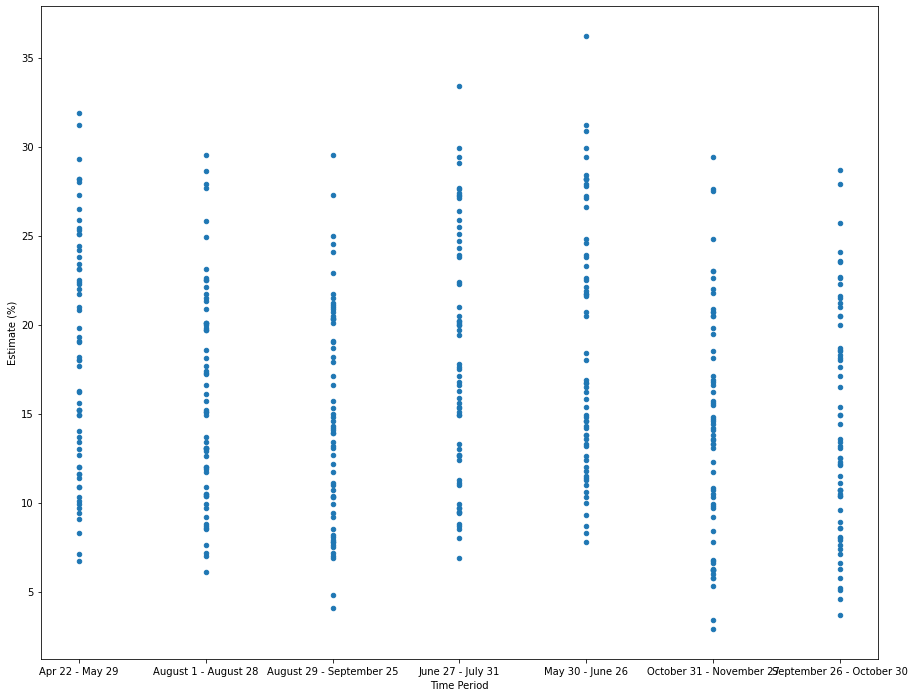

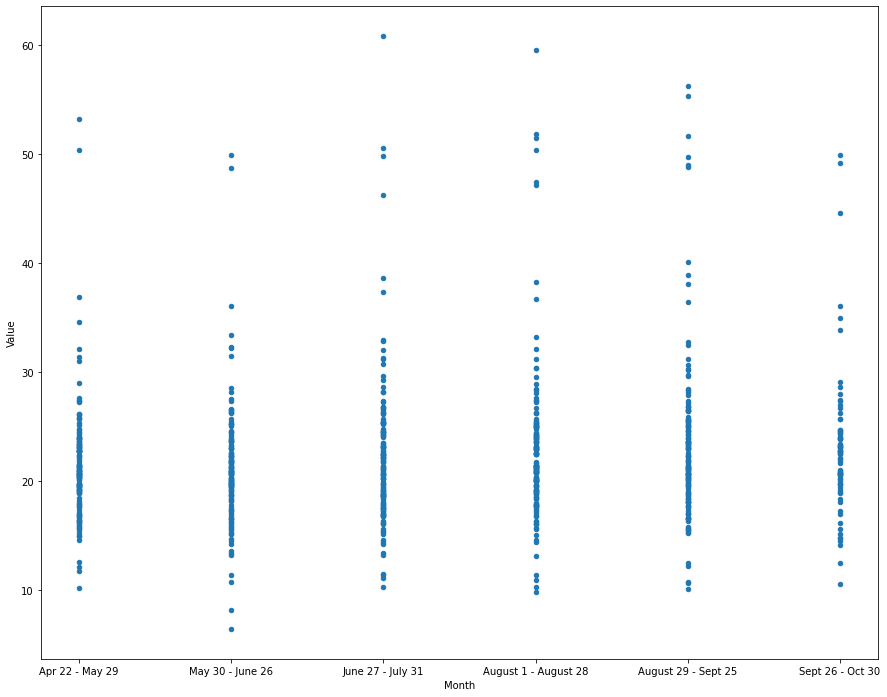

In [118]:
states_imm = monthly.loc[monthly["Group Name"] == 'All Adults 18+']
no_vacc = states_imm.loc[states_imm['Indicator Category'] == 'Probably or definitely will not get vaccinated']
no_vacc.plot(x = 'Time Period', y = 'Estimate (%)', kind = 'scatter', figsize = (15,12))
#print(states_imm['Indicator Category'].unique())
depresso = month_health.loc[month_health['Indicator'] == 'Symptoms of Depressive Disorder']
depresso.plot(x = 'Month', y = 'Value', kind = 'scatter', figsize = (15,12))

So we immediately notice two things looking at these plots.
1:
The team behind the immunization survey had the initial data alphabetically rather than chronologically sorted. Not the way I would have done it, but I don't work for the CDC. 
2: It seems that the average rate for experiencing symptoms of depression in a given state is around 20% and tends to stay there. There also exist a few seemingly ridiculous outliers on the top end for this dataset.
Conveniently for us the source page https://www.cdc.gov/nchs/covid19/pulse/mental-health.htm includes a very easy-to-navigate overview that quickly reveals said outliers aren't the data from states at large, but rather the data specifically from disabled and LGBT people. This is is rather interesting (and tragic), but it's not the topic we're going for in this tutorial. We will instead have everyone in a given state together in one pleasant little socially distanced pile.

Speaking of bringing together, it's about time we did a union of our semi-trimmed dataframes.

Data on immunization confidence retrieved from 
https://data.cdc.gov/Vaccinations/National-Immunization-Survey-Adult-COVID-Module-NI/udsf-9v7b 
on 12/18/2021

Data on symptoms of depression and anxiety retrieved from 
https://www.cdc.gov/nchs/covid19/pulse/mental-health.htm 
on 12/18/2021
